In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 15.0 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 83.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 146 kB 87.0 MB/s 
     |████████████████████████████████| 112 kB 93.9 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5efcc5fcf631f9e2c5ff3fc33b78083de611f5b8d18017f07726e82f22d66c8b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 14.6 MB/s 
     |████████████████████████████████| 596 kB 67.7 

In [71]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.

    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.

        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw

        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps


    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood

        Args:
            y_pred: network output
            y_actual: actual values

        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [4]:
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.

    Use this loss to make out of a DeepAR model a DeepVAR network.

    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric

        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )


    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
#         self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)


    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

In [69]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)

drop_col = ['keyword','topic_perc_contrib']
data_t = data.drop(drop_col, axis=1)
# data['keyword'] = data['keyword'].str.replace("<"," ")
# data_t = data.copy()
data_t['date'] = pd.to_datetime(data_t['date'], format='%Y-%m-%d')
data_t = data_t.sort_values('date').reset_index(drop=True)
data_t['time_index'] = np.arange(len(data))
data_t['time_index'] = data_t['time_index'].astype(int)
data_t['dominant_topic'] = data_t['dominant_topic'].astype(str).astype("category")


ord_col = data_t.dtypes.index[(data_t.dtypes.values != 'float64')].tolist()
scale_col = data_t.columns[~data_t.columns.isin(ord_col)].tolist()

# MinMaxScaler
scaler = MinMaxScaler()
data_t_scaled = scaler.fit_transform(data_t[scale_col])


data_scaled = pd.DataFrame(data_t_scaled, columns=scale_col)
res_data = pd.concat([data_scaled, data_t[ord_col]], axis=1)



In [70]:
res_data.head()

,oil_gsl,oil_hgsl,oil_lo,oil_du,oil_brt,oil_cl,cmdt_c,cmdt_gc,cmdt_pl,cmdt_si,...,avg_trade_price_by_dow,avg_trade_price_mo,date,dominant_topic,market,kr_holiday,us_holiday,dayofweek,month,time_index
0,0.319589,0.391863,0.235261,0.336845,0.365301,0.556933,0.129931,0.149206,0.494965,0.301641,...,0.156411,0.419724,2017-09-25,15.0,KRW-ETH,-,-,0,9,0
1,0.320996,0.389211,0.236338,0.335299,0.359963,0.554826,0.148730,0.138010,0.472670,0.286927,...,0.406098,0.419724,2017-09-26,15.0,KRW-ETH,-,-,1,9,1
2,0.322338,0.391311,0.237341,0.334332,0.354993,0.556437,0.139371,0.122472,0.468067,0.284097,...,1.000000,0.419724,2017-09-27,15.0,KRW-ETH,-,-,2,9,2
3,0.324008,0.387111,0.238661,0.334042,0.350483,0.552842,0.137857,0.124871,0.467635,0.285229,...,0.153142,0.419724,2017-09-28,15.0,KRW-ETH,-,-,3,9,3
4,0.326086,0.392905,0.240287,0.334332,0.351680,0.553524,0.140141,0.120302,0.452244,0.276174,...,0.000000,0.419724,2017-09-29,2.0,KRW-ETH,-,-,4,9,4


In [74]:
def objective(trial):

    cfg = { 'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0),
            'hidden_size' : trial.suggest_categorical('hidden_size', [16,32,64,128,256]),
            'max_epochs' : trial.suggest_int('max_epochs', 50, 151), 
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 1e-0),
            'rnn_layers' : trial.suggest_int('rnn_layers', 2, 6)
            } 

    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 90    # encoder LSTM에 들어가는 길이
    max_prediction_length = 20 # decoder의 길이

    # Training_cutoff는 trainingset을 정하기 위한 기준으로 max_prediction_length만 잘라서는 안될거 같음
    # 일단 데이터 기간의 30%를 validation으로 정의
    training_cutoff = int(res_data['time_index'].max() * .7)

    training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
        group_ids=["market"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals= ["trade_price"],
        time_varying_known_reals=["time_index","dayofweek","month"], 
        static_categoricals=["market"],
        add_relative_time_idx=False,
        add_target_scales=True,
        allow_missing_timesteps=True,
        randomize_length=(0.2, 0.05),
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        # stop_randomization=True
    )

    batch_size = 128
    train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
    val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)


    # Validation set의 정답지만 모아서 실제 관측치 만들기
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    print(f'Baseline SMAPE : {SMAPE()(baseline_predictions, actuals)}')

    net = DeepAR.from_dataset(
        training, 
        learning_rate=cfg['learning_rate'],
        log_interval=10,
        log_val_interval=1,
        hidden_size=cfg['hidden_size'],
        rnn_layers=cfg['rnn_layers'],
        loss= MultivariateNormalDistributionLoss(rank=30)
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
    lr_logger = LearningRateMonitor()

    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = 1,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  50,
        enable_checkpointing = True,
        auto_lr_find = True
        # logger = TensorBoardLogger('./lightning_logs/deepAR')
    )

    print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

    trainer.fit(
        net,
        train_dataloaders = train_dataloader,
        val_dataloaders = val_dataloader,
    )


    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = net.load_from_checkpoint(best_model_path)
    # print(f'Best Model : {best_model}')

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)

    return SMAPE()(predictions, actuals)

In [ ]:
# # save datasets
# training.save("training.pkl")
# validation.save("validation.pkl")

In [75]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=1)

[I 2022-06-17 02:30:36,743] A new study created in memory with name: no-name-ceee3bbf-4e29-476b-8b31-60883b008858
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs


Baseline SMAPE : 0.12225233018398285
Number of parameters in network: 10.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 10.3 K
4 | distribution_projector | Linear                             | 544   
------------------------------------------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -53.153


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.703 >= min_delta = 0.0001. New best score: -62.856


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.477 >= min_delta = 0.0001. New best score: -70.332


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 27.458 >= min_delta = 0.0001. New best score: -97.791


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 51.036 >= min_delta = 0.0001. New best score: -148.827


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 25.562 >= min_delta = 0.0001. New best score: -174.389


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 49.772 >= min_delta = 0.0001. New best score: -224.161


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.396 >= min_delta = 0.0001. New best score: -230.557


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.824 >= min_delta = 0.0001. New best score: -237.382


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.604 >= min_delta = 0.0001. New best score: -251.986


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.171 >= min_delta = 0.0001. New best score: -257.156


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.873 >= min_delta = 0.0001. New best score: -259.029


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -259.029. Signaling Trainer to stop.
[I 2022-06-17 02:32:21,790] Trial 0 finished with value: 0.6022102236747742 and parameters: {'learning_rate': 0.5191450458634524, 'hidden_size': 16, 'max_epochs': 132, 'gradient_clip_val': 0.0024117496488793963, 'rnn_layers': 5}. Best is trial 0 with value: 0.6022102236747742.


In [ ]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/DeepAR_optuna_key_220617_01.pkl')

['/content/deepar_optuna.pkl']

In [ ]:
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/DeepAR_optuna_key_220617_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.49562138319015503
 Params: 
    learning_rate: 0.43191245471719975
    hidden_size: 128
    dropout: 0
    max_epochs: 500
    gradient_clip_val: 0.0006675844851950232


ValueError: ignored

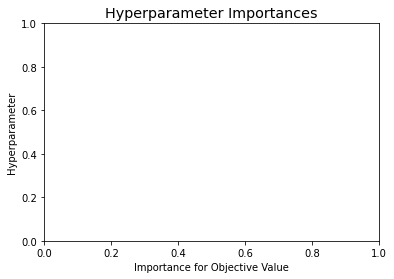

In [76]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

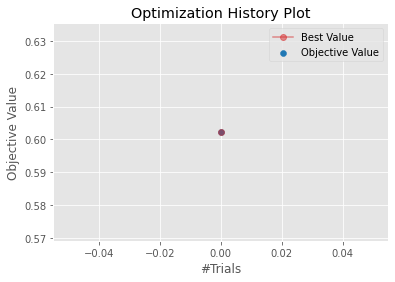



Number of finished trials:  1
Best trial:
  Value:  0.6022102236747742
  Params: 
    learning_rate: 0.5191450458634524
    hidden_size: 16
    max_epochs: 132
    gradient_clip_val: 0.0024117496488793963
    rnn_layers: 5


In [77]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [78]:
for i in np.arange(10, 20):
    plt.figure(figsize=(4, 3))
    plt.plot(predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()

NameError: ignored

<Figure size 288x216 with 0 Axes>

In [79]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 90
max_prediction_length = 20

# Training_cutoff는 trainingset을 정하기 위한 기준으로 max_prediction_length만 잘라서는 안될거 같음
# 일단 데이터 기간의 30%를 validation으로 정의
training_cutoff = int(res_data['time_index'].max() * .7)


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
        group_ids=["market"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals= ["trade_price"],
        time_varying_known_reals=["time_index","dayofweek","month"], 
        static_categoricals=["market"],
        add_relative_time_idx=False,
        add_target_scales=True,
        allow_missing_timesteps=True,
        randomize_length=(0.2, 0.05),
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1,
    # stop_randomization=True
)

batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

net = DeepAR.from_dataset(
    training, 
    learning_rate= study.best_params['learning_rate'],
    log_interval=10,
    log_val_interval=1,
    hidden_size= study.best_params['hidden_size'],
    rnn_layers= study.best_params['rnn_layers'],
    loss= MultivariateNormalDistributionLoss(rank=30)
)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs =  study.best_params['max_epochs'],
    gpus = 1,
    weights_summary = 'top',
    gradient_clip_val =  study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  50,
    enable_checkpointing = True,
    auto_lr_find = True
    # logger = TensorBoardLogger('./lightning_logs/deepAR')
)

print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)


best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)


print(f'MAE : {(actuals - predictions).abs().mean()}')

SMAPE = 2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8).mean()
print(f'SMAPE : {SMAPE}')


raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

market = validation.x_to_index(x)["market"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Market: {market.iloc[idx]}")


plt.figure(figsize=(6.77, 5))
plt.plot(predictions[0], label='prediction')
plt.plot(actuals[0], label='actual')
plt.suptitle('Timeseries Prediction')
plt.legend()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 10.3 K
4 | distribution_projector | Linear                             | 544   
------------------------------------------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)


Number of parameters in network: 10.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -39.519


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 20.340 >= min_delta = 0.0001. New best score: -59.860


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.112 >= min_delta = 0.0001. New best score: -61.972


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.364 >= min_delta = 0.0001. New best score: -69.336


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 20.520 >= min_delta = 0.0001. New best score: -89.856


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 46.341 >= min_delta = 0.0001. New best score: -136.197


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 78.079 >= min_delta = 0.0001. New best score: -214.276


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.533 >= min_delta = 0.0001. New best score: -217.809


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 34.543 >= min_delta = 0.0001. New best score: -252.352


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.857 >= min_delta = 0.0001. New best score: -254.208


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.086 >= min_delta = 0.0001. New best score: -255.294


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.041 >= min_delta = 0.0001. New best score: -258.335


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -258.335. Signaling Trainer to stop.


MAE : 0.16789941489696503
SMAPE : tensor([[0.1269, 0.0952, 0.2166,  ..., 0.3698, 0.3779, 0.3174],
        [0.2150, 0.1087, 0.2301,  ..., 0.3733, 0.2885, 0.3535],
        [0.2473, 0.0311, 0.2630,  ..., 0.2856, 0.3253, 0.3633],
        ...,
        [0.0021, 0.0344, 0.0992,  ..., 0.2689, 0.3034, 0.3767],
        [0.0197, 0.0506, 0.0720,  ..., 0.2846, 0.3625, 0.4064],
        [0.0938, 0.0119, 0.1175,  ..., 0.3546, 0.3994, 0.4120]])


_LinAlgError: ignored

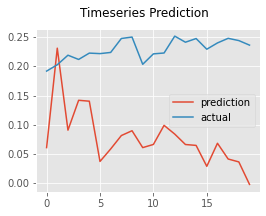

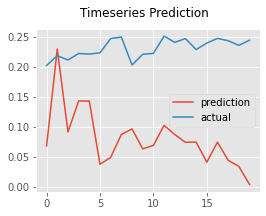

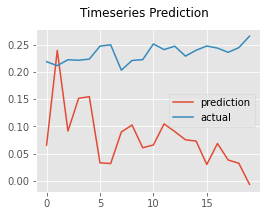

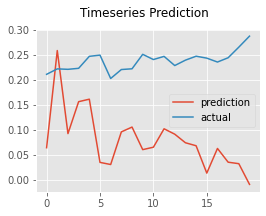

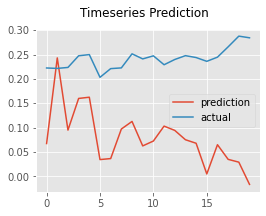

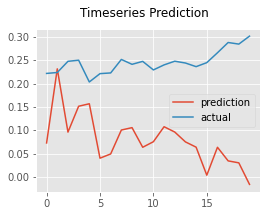

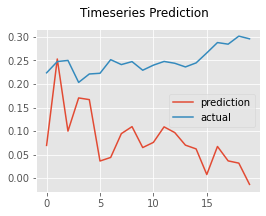

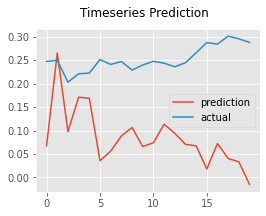

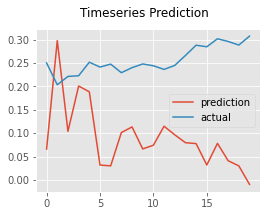

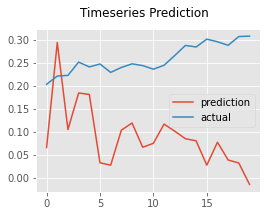

In [80]:
for i in np.arange(10, 20):
    plt.figure(figsize=(4, 3))
    plt.plot(predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()

In [82]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

market = validation.x_to_index(x)["market"]
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Market: {market.iloc[idx]}")


_LinAlgError: ignored

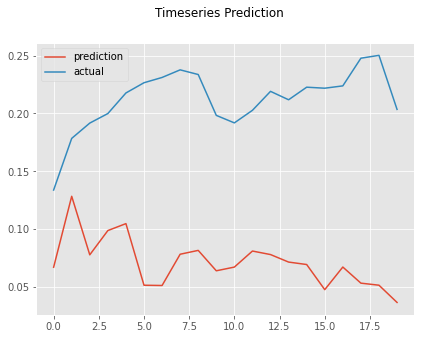

In [83]:



plt.figure(figsize=(6.77, 5))
plt.plot(predictions[0], label='prediction')
plt.plot(actuals[0], label='actual')
plt.suptitle('Timeseries Prediction')
plt.legend()

In [ ]:
best_model

DeepAR(
  (loss): MultivariateNormalDistributionLoss()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
    (4): MASE()
  )
  (embeddings): MultiEmbedding(
    (embeddings): ModuleDict()
  )
  (rnn): LSTM(4, 64, batch_first=True)
  (distribution_projector): Linear(in_features=64, out_features=12, bias=True)
)

In [84]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)

_LinAlgError: ignored

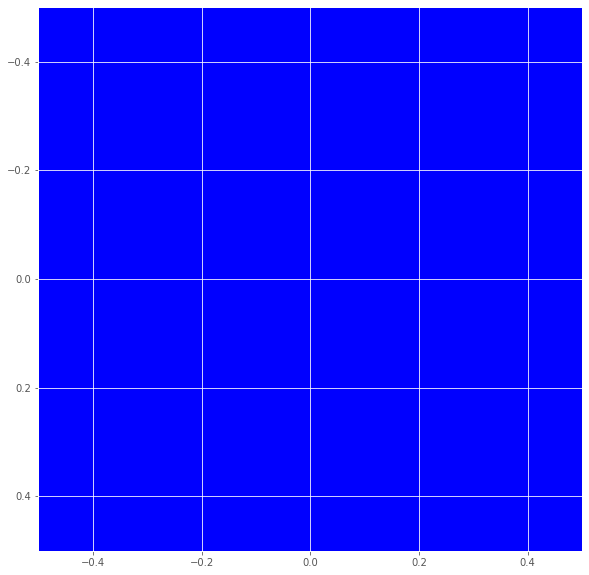

In [ ]:
cov_matrix = net.loss.map_x_to_distribution(
    net.predict(val_dataloader, mode=("raw", "prediction"), n_samples=None)
).covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix) * torch.diag(cov_matrix).T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="bwr");